# Agrupamiento de jugadores en base a su perfil de juego

El Poker Texas Hold'em, pese a ser considerado un juego de azar, involucra habilidad, probabilidades y psicología, donde comprender el comportamiento de los demás jugadores puede marcar la diferencia entre ganar o perder. Pues estas te ayudan a tomar decisiones estratégicas, cuando retirarte o cuando subir la apuesta.

En la actualidad, plataformas como GGPoker o PokerStars generan grandes volúmenes de datos sobre acciones de los jugadores, lo que abre posibilidades de aplicar algoritmos de aprendizaje automático para identificar estilos de juego. Analizar estos patrones permite clasificar a los jugadores en perfiles como tight, loose, agresivo o pasivo, proporcionando información útil para diseñar estrategias o sistemas de apoyo de decisión.

En este proyecto, buscaremos agrupar jugadores a partir del PHH (Poker Hands Histories) dataset mediante técnicas de clustering y analizar los resultados con el fin de etiquetar cada clúster como un estilo de jugador distinto.

Finalmente entregaremos un análisis interpretado de estos grupos, junto con la metodología implementada y recomendaciones basadas en los patrones detectados.

## Transformación de datos

Como se comento anteriormente, usaremos el PHH (Poker hands histories) dataset. Este dataset ha recolectado mas de 10 millones de manos de Poker jugadas desde casinos online o de grandes eventos del Poker. 

El principal inconveniente es su estructura, al estar en el formato .phhs no nos permite utilizar tecnologías como numpy o pandas. 

Ademas, aunque el dataset contiene información valiosa para nuestro objetivo, seria mucho mas útil contar con datos como el VPIP, PFR, AF, entre otras estadísticas clave de cada jugador. Estas métricas no vienen calculadas, pero pueden obtenerse procesando las manos del dataset.

Por ello, el primer paso será crear un nuevo csv usando los datos de nuestro dataset, calculando las métricas mencionadas y usando esa información en este proyecto, permitiendo optimizar el análisis posterior y facilitar el cálculo de las métricas avanzadas necesarias para el clustering.

In [21]:
import ast
import re
import csv
import os
import glob
import pandas as pd
from pathlib import Path
from collections import defaultdict, Counter

# Configuración de tokens
AGG_TOKEN = "cbr"
CALL_TOKEN = "cc" 
FOLD_TOKEN = "f"

def parse_list_line(line: str) -> list:
    if '=' not in line:
        return []
    rhs = line.split('=', 1)[1].strip()
    try:
        return ast.literal_eval(rhs)
    except Exception:
        m = re.search(r'\[.*\]', rhs)
        if m:
            try:
                return ast.literal_eval(m.group())
            except:
                pass
        return []

def parse_simple_value(line: str) -> str:
    if '=' not in line:
        return ""
    return line.split('=',1)[1].strip()

def split_hands(lines):
    hands = []
    current = []
    for ln in lines:
        s = ln.strip()
        if s.startswith('[') and s.endswith(']') and len(current) > 0:
            hands.append(current)
            current = []
        elif s == "" and len(current) > 0:
            hands.append(current)
            current = []
        else:
            current.append(ln)
    if current:
        hands.append(current)
    return hands

In [22]:
def extract_hand(block_lines):
    players = []
    actions = []
    seats = []
    
    for ln in block_lines:
        lns = ln.strip()
        if lns.startswith('players'):
            players = parse_list_line(lns)
        elif lns.startswith('actions'):
            actions = parse_list_line(lns)
        elif lns.startswith('seats'):
            seats = parse_list_line(lns)
    
    player_map = {}
    for idx, pid in enumerate(players, start=1):
        player_map[f"p{idx}"] = pid
    
    has_flop = any(a.startswith('d db') for a in actions)
    return {
        "players": players,
        "actions": actions,
        "player_map": player_map,
        "has_flop": has_flop
    }

def street_from_actions(actions):
    postflop = False
    for a in actions:
        if a.startswith('d db'):
            postflop = True
        yield ("postflop" if postflop else "preflop", a)

def parse_action_str(a: str):
    parts = a.split()
    if len(parts) < 2:
        return None
    if parts[0] == 'd':
        return None
    actor = parts[0]
    act = parts[1]
    amount = None
    if len(parts) >= 3:
        try:
            amount = float(parts[2])
        except Exception:
            amount = None
    return actor, act, amount

In [23]:
def extract_hand(block_lines):
    players = []
    actions = []
    seats = []
    
    for ln in block_lines:
        lns = ln.strip()
        if lns.startswith('players'):
            players = parse_list_line(lns)
        elif lns.startswith('actions'):
            actions = parse_list_line(lns)
        elif lns.startswith('seats'):
            seats = parse_list_line(lns)
    
    player_map = {}
    for idx, pid in enumerate(players, start=1):
        player_map[f"p{idx}"] = pid
    
    has_flop = any(a.startswith('d db') for a in actions)
    return {
        "players": players,
        "actions": actions,
        "player_map": player_map,
        "has_flop": has_flop
    }

def street_from_actions(actions):
    postflop = False
    for a in actions:
        if a.startswith('d db'):
            postflop = True
        yield ("postflop" if postflop else "preflop", a)

def parse_action_str(a: str):
    parts = a.split()
    if len(parts) < 2:
        return None
    if parts[0] == 'd':
        return None
    actor = parts[0]
    act = parts[1]
    amount = None
    if len(parts) >= 3:
        try:
            amount = float(parts[2])
        except Exception:
            amount = None
    return actor, act, amount

In [24]:
def accumulate_features(hands_blocks, min_hands=0, max_hands=None):
    hands_played = Counter()
    vpip_hands = Counter()
    pfr_hands = Counter()
    three_bet = Counter()
    
    preflop_decisions = defaultdict(lambda: Counter())
    postflop_bet_raise = Counter()
    postflop_call = Counter()
    cbet_opp = Counter()
    cbet_made = Counter()

    processed = 0

    for hb in hands_blocks:
        if max_hands is not None and processed >= max_hands:
            break

        hand = extract_hand(hb)
        players = hand["players"]
        if not players:
            continue
        processed += 1

        for pid in players:
            hands_played[pid] += 1

        pmap = hand["player_map"]

        hand_vpip = set()
        hand_pfr = set()

        preflop_raise_count = 0
        preflop_last_raiser_pid = None
        flop_seen = False

        for stage, raw in street_from_actions(hand["actions"]):
            parsed = parse_action_str(raw)
            if not parsed:
                continue

            actor, act, amount = parsed
            if actor not in pmap:
                continue

            pid = pmap[actor]

            if stage == "preflop":
                if act in [CALL_TOKEN, AGG_TOKEN]:
                    hand_vpip.add(pid)
                if act == AGG_TOKEN:
                    hand_pfr.add(pid)
                    preflop_raise_count += 1
                    if preflop_raise_count == 2:
                        three_bet[pid] += 1
                    preflop_last_raiser_pid = pid

                if act == FOLD_TOKEN:
                    preflop_decisions[pid]["fold"] += 1
                elif act == CALL_TOKEN:
                    preflop_decisions[pid]["call"] += 1
                elif act == AGG_TOKEN:
                    preflop_decisions[pid]["raise"] += 1

            elif stage == "postflop":
                if not flop_seen:
                    if preflop_last_raiser_pid:
                        cbet_opp[preflop_last_raiser_pid] += 1
                        if pid == preflop_last_raiser_pid and act == AGG_TOKEN:
                            cbet_made[pid] += 1
                    flop_seen = True
                if act == CALL_TOKEN:
                    postflop_call[pid] += 1
                elif act == AGG_TOKEN:
                    postflop_bet_raise[pid] += 1

        for pid in hand_vpip:
            vpip_hands[pid] += 1
        for pid in hand_pfr:
            pfr_hands[pid] += 1

    rows = []
    for pid, h in hands_played.items():
        if h < max(min_hands, 0):
            continue

        vpip_rate = vpip_hands[pid] / h if h else 0.0
        pfr_rate = pfr_hands[pid] / h if h else 0.0
        three_bet_rate = three_bet[pid] / h if h else 0.0

        dec = preflop_decisions[pid]
        total_dec = dec["fold"] + dec["call"] + dec["raise"]
        preflop_fold_pct = (dec["fold"] / total_dec) if total_dec else 0.0
        preflop_call_pct = (dec["call"] / total_dec) if total_dec else 0.0
        preflop_raise_pct = (dec["raise"] / total_dec) if total_dec else 0.0

        if postflop_call[pid] > 0:
            aggression_factor = postflop_bet_raise[pid] / postflop_call[pid]
        else:
            aggression_factor = 0.0

        cbet_opps = cbet_opp[pid]
        cbet_rate = (cbet_made[pid] / cbet_opps) if cbet_opps else 0.0

        rows.append([
            pid, h, vpip_rate, pfr_rate, three_bet_rate,
            preflop_fold_pct, preflop_call_pct, preflop_raise_pct,
            aggression_factor, cbet_rate
        ])

    return rows

def parse_file(path: str):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    return split_hands(lines)


In [25]:
DATASET_DIR = "poker-hand-histories"
OUTPUT_DIR = "processed_features" 
MIN_HANDS = 200
MAX_HANDS = None

os.makedirs(OUTPUT_DIR, exist_ok=True)

def find_phh_files(root_dir):
    phh_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.phh') or file.endswith('.phhs'):
                phh_files.append(os.path.join(root, file))
    return phh_files

phh_files = find_phh_files(DATASET_DIR)
print(f"Encontrados {len(phh_files)} archivos .phh/.phhs")

print("\n Primeros 5 archivos:")
for i, f in enumerate(phh_files[:5], 1):
    print(f"  {i}. {os.path.basename(f)}")

if len(phh_files) > 5:
    print(f"  ... y {len(phh_files)-5} más")
def process_single_file_notebook(file_path, min_hands=50, max_hands=None):
    """Procesa un archivo y retorna DataFrame"""
    try:
        hands_blocks = parse_file(file_path)
        rows = accumulate_features(hands_blocks, min_hands=min_hands, max_hands=max_hands)
        
        if rows:
            df = pd.DataFrame(rows, columns=[
                'player_id', 'hands_played', 'vpip', 'pfr', 'three_bet_pct',
                'preflop_fold_pct', 'preflop_call_pct', 'preflop_raise_pct',
                'aggression_factor', 'cbet_pct'
            ])
            df['source_file'] = os.path.basename(file_path)
            return df
        else:
            return None
            
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

# Procesar archivos
all_dataframes = []

for i, file_path in enumerate(phh_files, 1):
    print(f"[{i}/{len(phh_files)}] {os.path.basename(file_path)}")
    
    df = process_single_file_notebook(file_path, MIN_HANDS, MAX_HANDS)
    if df is not None:
        all_dataframes.append(df)
        print(f"{len(df)} jugadores extraídos")
    else:
        print(f"Sin datos válidos")
        
print(f"\nProcesados {len(all_dataframes)} archivos exitosamente")
# Combinar todos los DataFrames
if all_dataframes:
    final_df = pd.concat(all_dataframes, ignore_index=True)
    output_file = "all_players_features.csv"
    final_df.to_csv(output_file, index=False)
    print(f"- Guardado en: {output_file}")
    
else:
    print("No se procesaron datos")
    final_df = None

Encontrados 31870 archivos .phh/.phhs

 Primeros 5 archivos:
  1. phua-xuan-2019.phh
  2. antonius-blom-2009.phh
  3. dwan-ivey-2009.phh
  4. alice-carol-wikipedia.phh
  5. arieh-yockey-2019.phh
  ... y 31865 más
[1/31870] phua-xuan-2019.phh
Sin datos válidos
[2/31870] antonius-blom-2009.phh
Sin datos válidos
[3/31870] dwan-ivey-2009.phh
Sin datos válidos
[4/31870] alice-carol-wikipedia.phh
Sin datos válidos
[5/31870] arieh-yockey-2019.phh
Sin datos válidos
[6/31870] 58.phh
Sin datos válidos
[7/31870] 57.phh
Sin datos válidos
[8/31870] 82.phh
Sin datos válidos
[9/31870] 48.phh
Sin datos válidos
[10/31870] 52.phh
Sin datos válidos
[11/31870] 18.phh
Sin datos válidos
[12/31870] 25.phh
Sin datos válidos
[13/31870] 73.phh
Sin datos válidos
[14/31870] 59.phh
Sin datos válidos
[15/31870] 84.phh
Sin datos válidos
[16/31870] 45.phh
Sin datos válidos
[17/31870] 97.phh
Sin datos válidos
[18/31870] 70.phh
Sin datos válidos
[19/31870] 31.phh
Sin datos válidos
[20/31870] 47.phh
Sin datos válidos
[2

Finalmente conseguimos un csv con los features que queríamos y ademas mucho mas fácil de trabajar, nos brinda información vital  para este proyecto. 

# Leyenda de cabeceras.

player_id: Identificador único del jugador.

hands_played: Cantidad total de manos que ha jugado ese jugador.

vpip (Voluntarily Put $ In Pot)
Porcentaje de manos en las que el jugador entra voluntariamente al pozo (pagando o subiendo). Mide lo loose/tight que es.

pfr (PreFlop Raise)
Porcentaje de manos en las que el jugador hace raise preflop. Mide agresividad preflop.

three_bet_pct
Porcentaje de manos en las que el jugador hace 3-bet (resube una subida preflop).

preflop_fold_pct
Porcentaje de veces que el jugador foldea preflop.

preflop_call_pct
Porcentaje de veces que el jugador paga preflop.

preflop_raise_pct
Porcentaje de veces que el jugador sube preflop.
(A veces coincide o deriva de PFR).

aggression_factor (AF)
Métrica postflop: (bets + raises) / calls.
Indica cuán agresivo es el jugador después del flop.

cbet_pct (Continuation Bet)
Porcentaje de veces que el jugador hace una apuesta de continuación cuando fue agresor preflop.

source_file
Archivo origen del cual se extrajeron estas estadísticas-

## EDA

Librerias:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from umap import UMAP

/home/gabo/Desktop/utec/MachineLearning/p3_notebook/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gracias a estos cambios, podemos realizar el EDA con el objetivo de comprender la estructura general de los datos, identificar posibles patrones y detectar valores atípicos que puedan influir en los resultados del modelado.

Para ello, cargamos el dataset procesado, filtramos jugadores con al menos 200 manos jugadas para asegurar estabilidad estadística, y exploramos la forma, tipos de datos, valores faltantes y estadísticas descriptivas de cada variable.

Este EDA nos permitirá tener una visión clara del comportamiento general de los jugadores y sentará las bases para seleccionar y justificar los modelos de clustering apropiados en las siguientes etapas del proyecto.

In [3]:
df = pd.read_csv("all_players_features.csv")
df = df[df["hands_played"] >= 200]
print("Dimensiones:", df.shape)
df.head()
df.info()
print("\n=== VERIFICACIÓN DE NULOS ===")
null_counts = df.isna().sum()
print(null_counts)

# Mostrar columnas que tienen al menos UN valor nulo
cols_with_nulls = null_counts[null_counts > 0]
print("\nColumnas con valores nulos:")
print(cols_with_nulls if len(cols_with_nulls) > 0 else "No hay columnas con valores nulos")

print("=== DESCRIPCIÓN ESTADÍSTICA ===")

# Extraemos las estadísticas básicas que necesitamos
stats = df.describe().loc[['min', 'max', 'mean', 'std']]

# Transponemos para que sea más legible columna por columna
stats = stats.T  

# Redondeamos para que sea bonito
stats_rounded = stats.round(4)

print(stats_rounded)

df.describe()

Dimensiones: (43414, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43414 entries, 0 to 43413
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id          43414 non-null  object 
 1   hands_played       43414 non-null  int64  
 2   vpip               43414 non-null  float64
 3   pfr                43414 non-null  float64
 4   three_bet_pct      43414 non-null  float64
 5   preflop_fold_pct   43414 non-null  float64
 6   preflop_call_pct   43414 non-null  float64
 7   preflop_raise_pct  43414 non-null  float64
 8   aggression_factor  43414 non-null  float64
 9   cbet_pct           43414 non-null  float64
 10  source_file        43414 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 3.6+ MB

=== VERIFICACIÓN DE NULOS ===
player_id            0
hands_played         0
vpip                 0
pfr                  0
three_bet_pct        0
preflop_fold_pct     0
preflop_cal

,hands_played,vpip,pfr,three_bet_pct,preflop_fold_pct,preflop_call_pct,preflop_raise_pct,aggression_factor,cbet_pct
count,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000
mean,304.580734,0.248144,0.172085,0.024036,0.735429,0.087922,0.176649,0.633296,0.232329
std,112.880069,0.081506,0.064028,0.014835,0.091989,0.058509,0.069164,0.985260,0.136367
min,200.000000,0.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,226.000000,0.202290,0.136842,0.013986,0.708197,0.056818,0.140097,0.421053,0.142857
50%,266.000000,0.236607,0.167198,0.022222,0.749428,0.076555,0.171103,0.562500,0.222222
75%,343.000000,0.275445,0.199038,0.031674,0.785425,0.101942,0.202970,0.742857,0.312500
max,1000.000000,1.000000,0.717489,0.239234,0.959184,1.000000,0.786982,120.000000,1.000000


El dataset filtrado contiene 35,596 jugadores, cada uno con al menos 200 manos jugadas, lo que asegura que las estadísticas calculadas sean más estables y representativas. La tabla cuenta con 11 variables, principalmente métricas porcentuales del comportamiento preflop y postflop, además del número total de manos jugadas y el identificador del jugador.

La exploración inicial muestra que no existen valores nulos. Las estadísticas descriptivas permiten observar tendencias importantes: los jugadores tienen en promedio alrededor de 288 manos analizadas, un VPIP medio de ~25% y un PFR alrededor de ~17%, lo cual es consistente con rangos típicos en mesas No-Limit Texas Hold’em. Además, se observan amplias variaciones entre jugadores, lo que sugiere que el dataset contiene suficiente diversidad de estilos para aplicar técnicas de clustering.

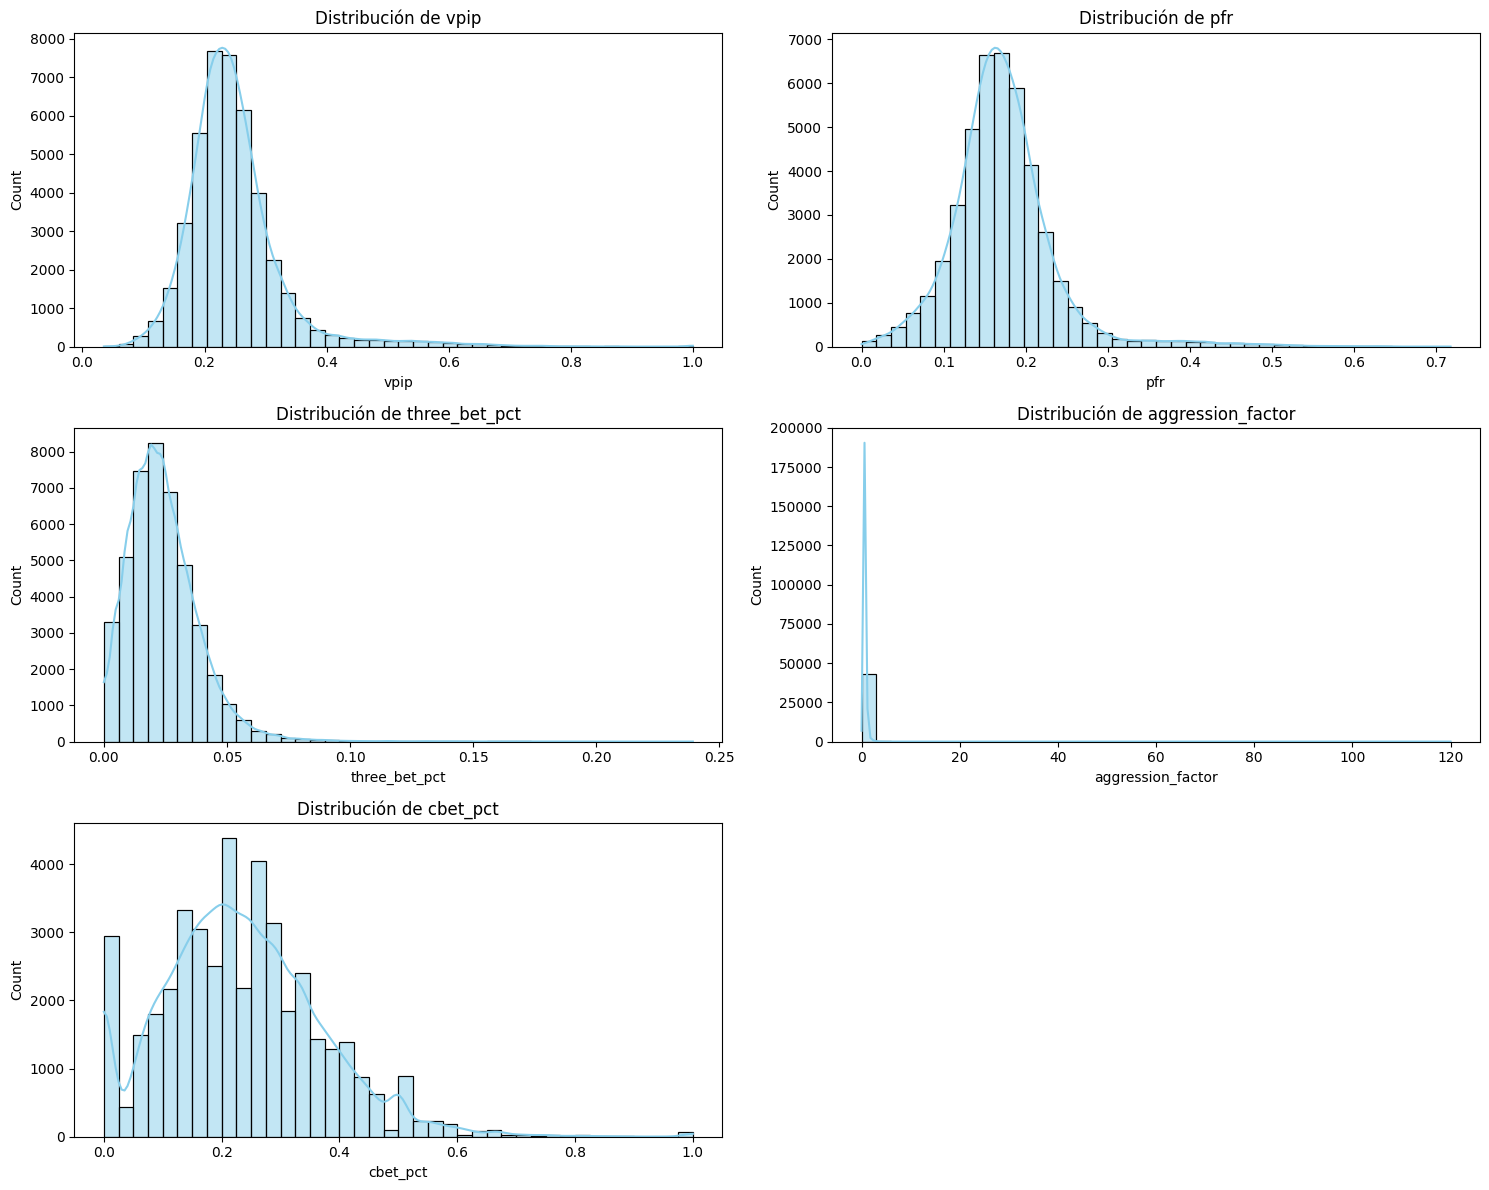

In [4]:
variables = ["vpip", "pfr", "three_bet_pct", "aggression_factor", "cbet_pct"]

plt.figure(figsize=(15, 12))

for i, col in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=40, kde=True, color="skyblue")
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

Con estos histogramas podemos notar las distribuciones de cada variable. La distribución de VPIP se concentra principalmente entre 0.20 y 0.30, lo que indica que la mayoría de jugadores participa voluntariamente en una proporción relativamente reducida de manos. Este comportamiento es característico de jugadores tight. La cola derecha más larga sugiere la presencia de jugadores loose, pero constituyen un grupo minoritario.
El PFR muestra una distribución similar a la de VPIP, centrada entre 0.10 y 0.20, pero con valores más bajos, lo cual es esperado porque no todos los jugadores que entran en una mano deciden subirla. Esto refleja un predominio de estilos tight-passive o tight-aggressive moderados, ya que la frecuencia de subida suele ser menor que la de participación.

El three-bet porcentaje presenta una distribución altamente sesgada hacia valores cercanos a cero, concentrándose entre 0.00 y 0.05. Esto confirma que el three-bet es una acción relativamente poco frecuente en el póker, realizada solo por jugadores realmente agresivos o en situaciones estratégicas. La cola hacia la derecha refleja un pequeño grupo de jugadores muy agresivos preflop, que serán importantes para el clustering.

La distribución del aggression factor es la más extrema. Existe una gran acumulación de valores cercanos a cero, pero también una cola muy pronunciada que se extiende a valores altos (incluso mayores a 100). Esto revela que, aunque la mayoría de jugadores muestra niveles de agresión moderada, existe un subconjunto de jugadores con estilos extremadamente agresivos, o con patrones de apuesta muy desbalanceados. Esta variable es clave para diferenciar estilos pasivos, agresivos y ultra-agresivos.

El porcentaje de continuation bet tiene una distribución más amplia, típicamente entre 0.20 y 0.50, lo cual refleja que una proporción considerable de jugadores realiza apuestas de continuación tras subir preflop. La cola hacia valores más altos muestra jugadores que c-betean muy frecuentemente, lo que se asocia a estilos agresivos y estrategias de presión postflop.

## Boxplot

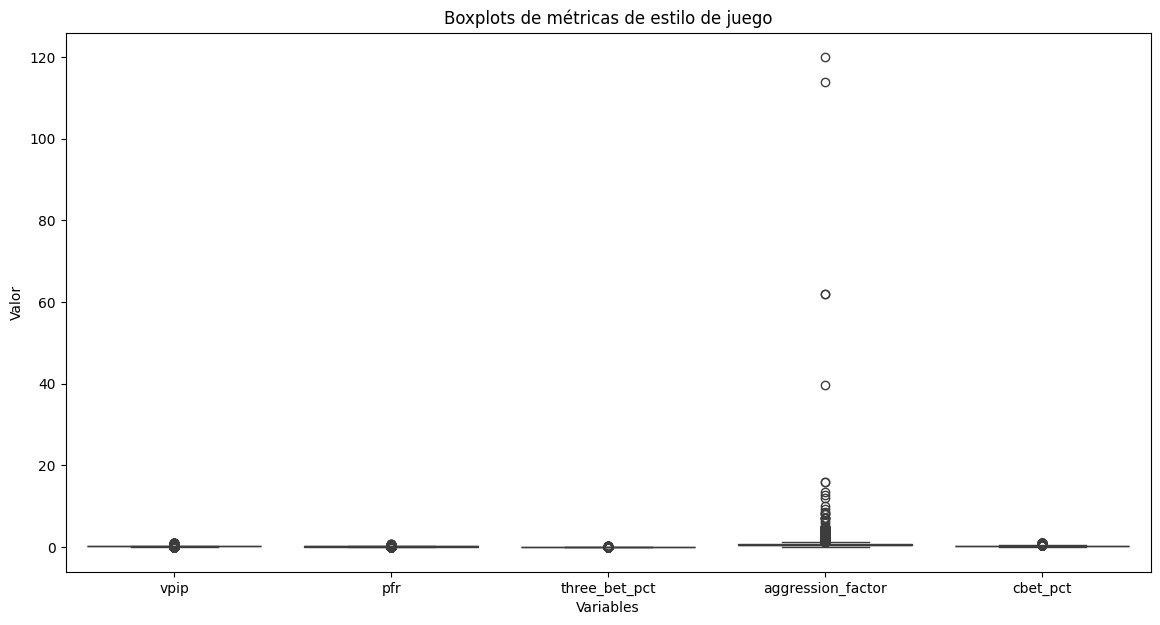

In [5]:
ariables = ["vpip", "pfr", "three_bet_pct", "aggression_factor", "cbet_pct"]

plt.figure(figsize=(14, 7))
sns.boxplot(data=df[variables], orient="v", color="lightgreen")
plt.title("Boxplots de métricas de estilo de juego")
plt.ylabel("Valor")
plt.xlabel("Variables")
plt.show()


Al observar el boxplot de las métricas de estilo de juego, podemos notar que la mayoría de variables (VPIP, PFR, Three-bet % y C-bet %) presentan valores concentrados en rangos relativamente pequeños, tal como ya se apreciaba en los histogramas. Esto indica que, en general, los jugadores tienden a comportarse de manera similar en estas métricas, sin grandes desviaciones.

Sin embargo, la variable Aggression Factor muestra una situación distinta. Aparecen muchos puntos alejados del cuerpo principal del gráfico. Estos puntos representan valores que están muy por encima de la mayoría y sugieren que algunos jugadores muestran niveles de agresión mucho más altos que el resto.

Por ahora, solo podemos concluir que estas observaciones se salen del patrón común y que conviene analizarlas para entender por qué ocurren y si tienen algún significado especial dentro del comportamiento de los jugadores.

## Exploración de outliners


Después de graficar los boxplots, realizamos un análisis más detallado para identificar cuántos valores se encuentran fuera del rango considerado “normal” para cada variable. Para esto utilizamos el método del IQR (Interquartile Range), que nos permite detectar valores que se encuentran demasiado alejados del resto.

In [6]:
def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inf) | (df[col] > limite_sup)]
    return outliers

for col in variables:
    outliers_col = detectar_outliers(col)
    print(f"{col}: {len(outliers_col)} outliers")

vpip: 2194 outliers
pfr: 2046 outliers
three_bet_pct: 1002 outliers
aggression_factor: 1683 outliers
cbet_pct: 675 outliers


A partir de estos números, podemos notar que todas las métricas presentan valores atípicos, aunque algunas en mayor cantidad que otras. Esto coincide con lo que vimos en los boxplots: ciertas estadísticas del comportamiento de los jugadores presentan valores que se salen del patrón general.

En esta etapa todavía no podemos concluir si estos outliers representan errores, comportamientos muy extremos o simplemente variaciones normales del juego. Lo que sí podemos afirmar por ahora es que existen diferencias marcadas en cómo se distribuyen las acciones de diferentes jugadores, especialmente en métricas como vpip, pfr y aggression_factor, donde la cantidad de outliers es bastante alta.

In [7]:
def get_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    return df[(df[col] < low) | (df[col] > high)]

outliers_dict = {col: get_outliers(df, col) for col in variables}

print(outliers_dict)

{'vpip':                     player_id  hands_played      vpip       pfr  \
1      iv3F5Nfys2jHNHLe8Jwmpw           465  0.412903  0.191398   
13     whII2SZ20yqQx+ZGRBjlBw           229  0.436681  0.196507   
72     OFg0obyw+NI9BjaBBgAbOw           250  0.584000  0.300000   
80     MVJd9rZohe/E+wAmu5oBpw           245  0.534694  0.163265   
124    YbFnGjjEVbxKItR5dVWToQ           314  0.404459  0.324841   
...                       ...           ...       ...       ...   
43170  DV7z9P+tl+dmeMuTRjTvIQ           217  0.470046  0.419355   
43276  Vm33eaMxSkdgn2uDA36gSg           209  0.411483  0.363636   
43309  h32ByHFjZlKtiLJEwtGbMA           272  0.463235  0.441176   
43321  5qnAc9dftZIWcf9K/KtwgA           243  0.049383  0.032922   
43376  MBLAoorRj6S1Tx/9VOooiQ           210  0.485714  0.404762   

       three_bet_pct  preflop_fold_pct  preflop_call_pct  preflop_raise_pct  \
1           0.019355          0.557895          0.250526           0.191579   
13          0.039301        

Al revisar directamente los valores que fueron detectados como outliers, podemos observar que estos registros no provienen de jugadores con pocas manos jugadas, sino que muestran cantidades bastante razonables, como 200, 250 o incluso más de 300 manos. Esto es importante porque indica que estos valores no parecen ser producto de falta de información o de muestras demasiado pequeñas, sino que pertenecen a jugadores con suficiente actividad para considerarse representativos. Además, al inspeccionar las columnas, es evidente que estos valores atípicos no aparecen solo en una métrica aislada, sino que muchos jugadores muestran comportamientos inusuales en varias estadísticas al mismo tiempo, como VPIP, PFR o porcentajes de apuesta y resubida. Esto sugiere que, más que errores, podrían corresponder a estilos de juego diferentes del patrón general observado en los histogramas.

Otro detalle relevante es que los valores detectados como outliers siguen estando dentro de rangos posibles del póker: VPIP mayores al 0.45, porcentajes de 3-bet relativamente altos o stats como fold y raise cercanos a 1. Aunque son extremos, no parecen imposibles ni contradictorios. Esto hace pensar que estos jugadores podrían representar comportamientos particularmente agresivos, pasivos o desbalanceados dentro del juego.

In [8]:
for col, df_out in outliers_dict.items():
    print(f"\n{col} — resumen de manos jugadas en outliers")
    print(df_out["hands_played"].describe())



vpip — resumen de manos jugadas en outliers
count    2194.000000
mean      270.407475
std        80.531436
min       200.000000
25%       217.000000
50%       245.000000
75%       293.000000
max       868.000000
Name: hands_played, dtype: float64

pfr — resumen de manos jugadas en outliers
count    2046.000000
mean      274.196481
std        85.074220
min       200.000000
25%       217.000000
50%       247.500000
75%       300.000000
max       997.000000
Name: hands_played, dtype: float64

three_bet_pct — resumen de manos jugadas en outliers
count    1002.000000
mean      281.926148
std        94.861203
min       200.000000
25%       219.000000
50%       253.000000
75%       308.000000
max      1000.000000
Name: hands_played, dtype: float64

aggression_factor — resumen de manos jugadas en outliers
count    1683.000000
mean      276.617350
std        86.323492
min       200.000000
25%       219.000000
50%       248.000000
75%       304.000000
max       910.000000
Name: hands_played, dt

Para entender mejor si los valores atípicos podrían deberse a escasez de datos, revisamos cuántas manos jugadas tienen los jugadores que aparecen como outliers en cada métrica. Los resúmenes estadísticos muestran que, en todas las variables, los jugadores considerados como outliers tienen cantidades de manos bastante altas: los mínimos rondan las 200 manos, y los promedios se ubican entre 240 y 280 manos jugadas, con máximos que en algunos casos superan las 600 o 800 manos. Esto sugiere que estos valores atípicos no provienen de muestras pequeñas ni de registros poco confiables, sino de jugadores que han participado en un número considerable de manos.

no eliminar outliners

## Correlacion de variables

Al analizar los boxplots de las variables del dataset, se observa la presencia de valores extremos en métricas como aggression_factor, 3bet_pct y cbet_pct. Estos outliers pueden deberse a dos causas principales: jugadores con comportamientos extremadamente agresivos o, más comúnmente, jugadores con un número muy reducido de manos registradas, lo que genera variabilidad estadística y valores poco representativos.

Dado que el objetivo del proyecto incluye la aplicación de técnicas de clustering, es importante considerar que modelos como K-means son sensibles a la presencia de outliers, ya que estos pueden distorsionar los centroides y generar agrupaciones poco fiables. Por esta razón, se evaluarán estrategias para mitigar su impacto sin eliminar información relevante.

Finalmente, antes de aplicar cualquier modelo, se revisarán las correlaciones entre las variables, ya que métricas como VPIP, PFR y 3bet suelen estar fuertemente relacionadas. Esto permitirá reducir redundancias y seleccionar un conjunto de características más estable para el análisis. De esta manera, se logra un equilibrio entre conservar información valiosa sobre estilos de juego extremos y asegurar la calidad de los resultados de los modelos.

## Mapa de correlación

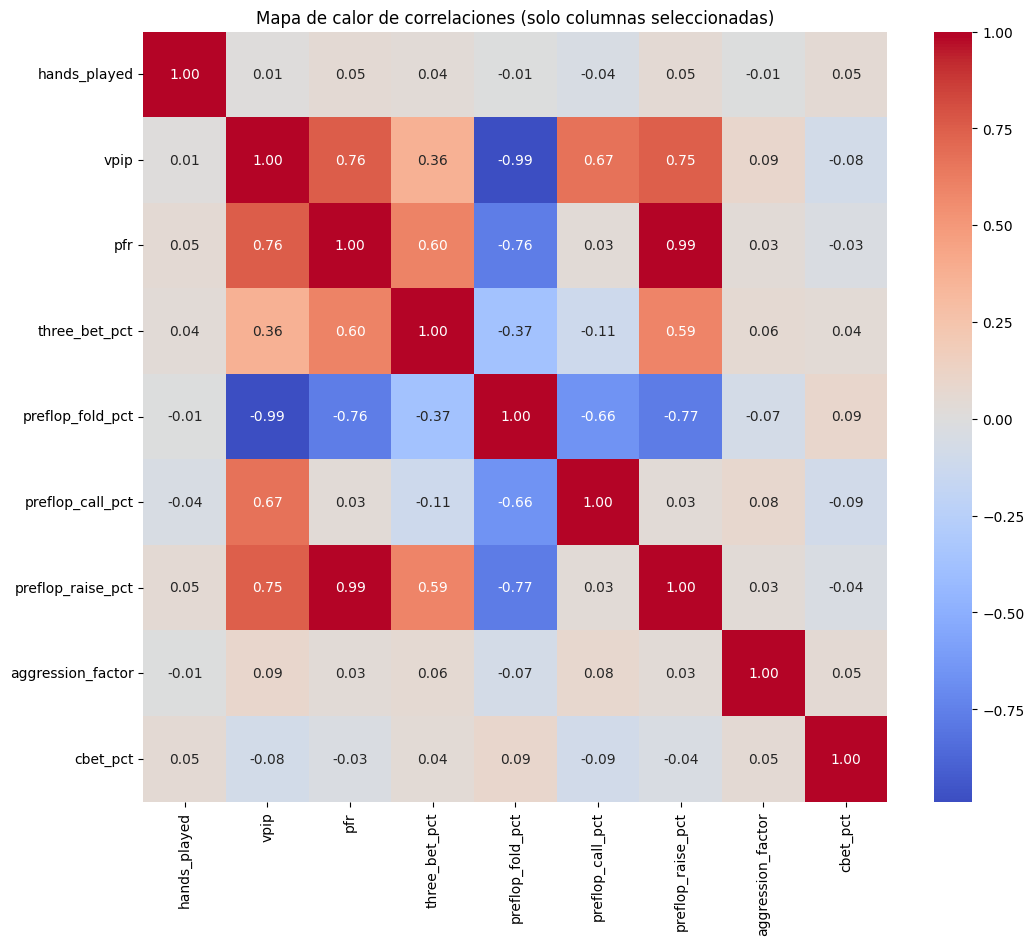


### Correlaciones más POSITIVAS ###
       Variable_1        Variable_2  Correlacion
              pfr preflop_raise_pct     0.991211
              pfr              vpip     0.758151
preflop_raise_pct              vpip     0.750250
 preflop_call_pct              vpip     0.667049
              pfr     three_bet_pct     0.603248
preflop_raise_pct     three_bet_pct     0.590544
    three_bet_pct              vpip     0.363576
aggression_factor              vpip     0.088021
         cbet_pct  preflop_fold_pct     0.086016
aggression_factor  preflop_call_pct     0.080112

### Correlaciones más NEGATIVAS ###
       Variable_1        Variable_2  Correlacion
     hands_played  preflop_call_pct    -0.044076
aggression_factor  preflop_fold_pct    -0.072920
         cbet_pct              vpip    -0.084884
         cbet_pct  preflop_call_pct    -0.093661
 preflop_call_pct     three_bet_pct    -0.114397
 preflop_fold_pct     three_bet_pct    -0.371251
 preflop_call_pct  preflop_fold_pct    -0.65

In [9]:
df = pd.read_csv("all_players_features.csv")

# Seleccionar solo las columnas que quieres
cols = [
    "hands_played", "vpip", "pfr", "three_bet_pct",
    "preflop_fold_pct", "preflop_call_pct", "preflop_raise_pct",
    "aggression_factor", "cbet_pct"
]

df_sub = df[cols]

# Matriz de correlación
corr_matrix = df_sub.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones (solo columnas seleccionadas)")
plt.show()

# -------------------------------------------------------
#cLista de correlaciones más positivas y negativas


# Convertir matriz de correlación a formato largo
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ["Variable_1", "Variable_2", "Correlacion"]

# Eliminar la diagonal (correlación de variable consigo misma)
corr_pairs = corr_pairs[corr_pairs["Variable_1"] != corr_pairs["Variable_2"]]

# Eliminar duplicados A-B y B-A
corr_pairs = corr_pairs[
    corr_pairs.apply(lambda row: row["Variable_1"] < row["Variable_2"], axis=1)
]

# Ordenar descendentemente por correlación
corr_sorted = corr_pairs.sort_values("Correlacion", ascending=False)

# Imprimir TOP correlaciones positivas
print("\n### Correlaciones más POSITIVAS ###")
print(corr_sorted.head(10).to_string(index=False))

# Imprimir TOP correlaciones negativas
print("\n### Correlaciones más NEGATIVAS ###")
print(corr_sorted.tail(10).to_string(index=False))

El mapa de calor nos permite observar cómo se relacionan entre sí las diferentes métricas de estilo de juego. En general, se aprecia que varias de las variables muestran patrones de correlación consistentes con lo que vimos previamente en los histogramas y boxplots. Por ejemplo, VPIP y PFR presentan una correlación alta y positiva, lo cual tiene sentido porque los jugadores que entran en muchas manos suelen también subir con más frecuencia. De forma similar, PFR también se relaciona positivamente con el porcentaje de resubida preflop (preflop_raise_pct), mostrando que estos comportamientos suelen ir de la mano.

Otro patrón evidente es la correlación negativa casi perfecta entre VPIP y preflop_fold_pct. Esto refleja que, cuando un jugador participa voluntariamente en muchas manos, es menos probable que foldee preflop, mientras que los jugadores que foldean mucho suelen tener un VPIP muy bajo. También se observan correlaciones moderadas entre estadísticas relacionadas, como PFR con three_bet_pct, lo cual es lógico dado que ambas describen acciones agresivas antes del flop.

Por otro lado, métricas como aggression_factor y cbet_pct no muestran correlaciones fuertes con la mayoría de variables, lo que sugiere que estos comportamientos postflop varían de manera más independiente respecto a las decisiones preflop. Asimismo, la cantidad de manos jugadas (hands_played) prácticamente no tiene relación con ninguna métrica, lo cual es esperable, porque el número de manos solo indica actividad y no refleja un estilo particular.

## Reducir dimencionalidad

In [10]:
print(df.columns)

cols_keep = [
    "player_id",
    "hands_played",
    "vpip",
    "pfr",
    "three_bet_pct",
    "aggression_factor",
    "cbet_pct"
]

df_reduced = df[cols_keep].copy()

print(df_reduced.columns)
df_reduced.head()
# Guardar el DataFrame reducido en un nuevo CSV
df_reduced.to_csv("players_features_reduced.csv", index=False)

Index(['player_id', 'hands_played', 'vpip', 'pfr', 'three_bet_pct',
       'preflop_fold_pct', 'preflop_call_pct', 'preflop_raise_pct',
       'aggression_factor', 'cbet_pct', 'source_file'],
      dtype='object')
Index(['player_id', 'hands_played', 'vpip', 'pfr', 'three_bet_pct',
       'aggression_factor', 'cbet_pct'],
      dtype='object')


## Normalización

Robust StandardScaler

In [11]:
from sklearn.preprocessing import RobustScaler
vars_num = ["vpip", "pfr", "three_bet_pct", "aggression_factor", "cbet_pct"]

scaler = RobustScaler()

df_scaled = df_reduced.copy()
df_scaled[vars_num] = scaler.fit_transform(df_reduced[vars_num])

df_scaled.head()

,player_id,hands_played,vpip,pfr,three_bet_pct,aggression_factor,cbet_pct
0,m1gIgIfiyRvt/kuTI+uxTQ,247,-0.135144,-0.214667,-1.027445,-0.632451,0.833599
1,iv3F5Nfys2jHNHLe8Jwmpw,465,2.409888,0.389100,-0.162107,-0.286602,-0.327485
2,Zj8+grrfslgwuWwD48KsGA,226,-0.754439,-0.340535,-0.756022,1.077023,-0.046784
3,svH7x+Oa+CamROZNoG+gQg,329,-0.242801,0.146220,1.493086,1.255938,1.482302
4,bRbvTgPlIR1/xtJ+miVqxw,537,-0.179665,0.156140,-0.308819,0.546796,-0.739483


In [12]:
df_scaled[vars_num].describe()


,vpip,pfr,three_bet_pct,aggression_factor,cbet_pct
count,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000
mean,0.157709,0.078578,0.102537,0.219998,0.059577
std,1.114152,1.029463,0.838680,3.061673,0.803846
min,-2.755878,-2.688246,-1.256331,-1.747956,-1.309942
25%,-0.469099,-0.488062,-0.465633,-0.439544,-0.467836
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.530901,0.511938,0.534367,0.560456,0.532164
max,10.435235,8.847731,12.268761,371.149241,4.584795


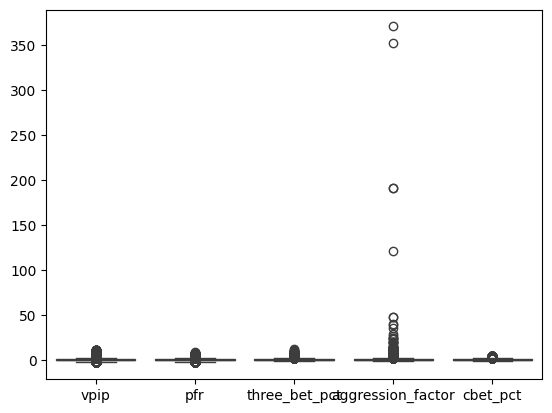

In [13]:
sns.boxplot(data=df_scaled[vars_num])
plt.show()


# PCA

Varianza explicada por 2 componentes:
[0.36283445 0.17887591]

Varianza explicada por 3 componentes:
[0.36283445 0.17887591 0.1682661 ]


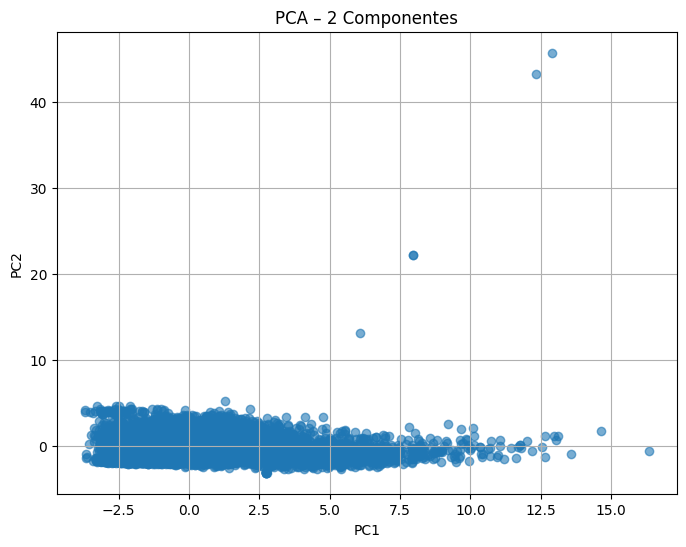

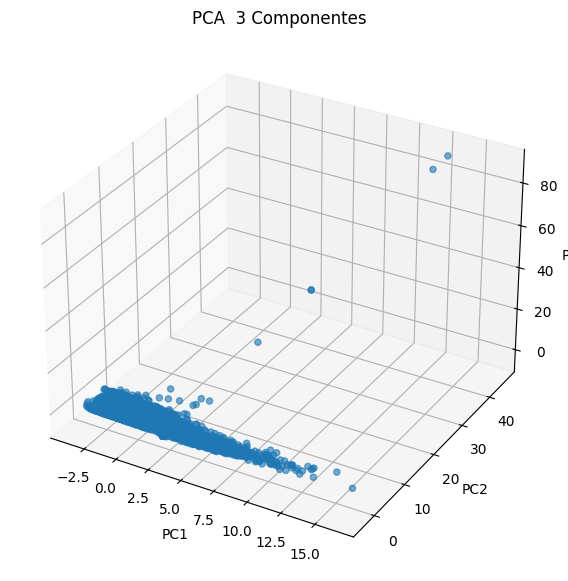

In [14]:
# -------------------------
# 1. Leer datos
# -------------------------

# Opcional: elimina columnas no numéricas (ej: player_id, source_file)
df_features = df_reduced.select_dtypes(include=["float64", "int64"])

# -------------------------
# 2. Escalar datos
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# -------------------------
# 3. PCA – 2 componentes
# -------------------------
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

print("Varianza explicada por 2 componentes:")
print(pca_2.explained_variance_ratio_)

# -------------------------
# 4. PCA – 3 componentes
# -------------------------
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

print("\nVarianza explicada por 3 componentes:")
print(pca_3.explained_variance_ratio_)

# -------------------------
# 5. Gráfica PCA 2D
# -------------------------
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2[:,0], X_pca_2[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – 2 Componentes")
plt.grid(True)
plt.show()

# -------------------------
# 6. Gráfica PCA 3D
# -------------------------
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3[:,0], X_pca_3[:,1], X_pca_3[:,2], alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA  3 Componentes")
plt.show()


Dimensiones de los datos: (43414, 6)
Columnas numéricas: ['hands_played', 'vpip', 'pfr', 'three_bet_pct', 'aggression_factor', 'cbet_pct']
Ejecutando UMAP...
UMAP(random_state=42, verbose=True)
Mon Nov 24 19:43:23 2025 Construct fuzzy simplicial set
Mon Nov 24 19:43:23 2025 Finding Nearest Neighbors
Mon Nov 24 19:43:23 2025 Building RP forest with 15 trees


/home/gabo/Desktop/utec/MachineLearning/p3_notebook/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Nov 24 19:43:25 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Nov 24 19:43:34 2025 Finished Nearest Neighbor Search
Mon Nov 24 19:43:36 2025 Construct embedding


Epochs completed:   2%| ▏          4/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         24/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▏        44/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  33%| ███▎       66/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      84/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     104/200 [00:07]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    124/200 [00:08]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   144/200 [00:10]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  164/200 [00:11]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 184/200 [00:12]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:13]


Mon Nov 24 19:43:53 2025 Finished embedding


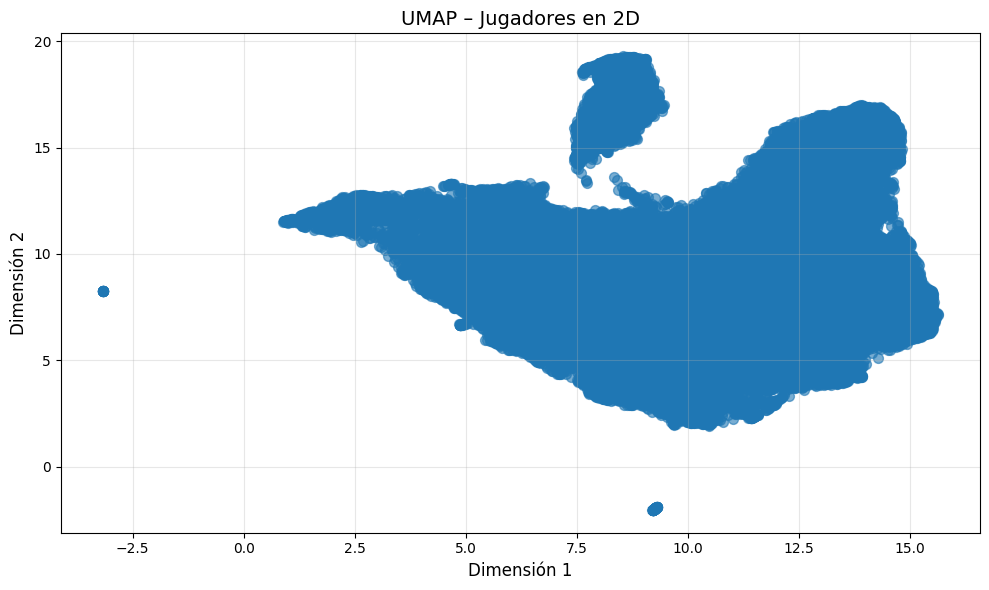


Reducción completada: 6 dimensiones -> 2 dimensiones


In [15]:
# -------------------------------------------------------
# 1. Cargar CSV
# -------------------------------------------------------
df = pd.read_csv("players_features_reduced.csv")

# -------------------------------------------------------
# 2. Eliminar columnas no numéricas
# -------------------------------------------------------
df_num = df.drop(columns=["player_id", "source_file"], errors="ignore")
df_num = df_num.select_dtypes(include=['float64', 'int64'])

# Verificar que tenemos datos
print(f"Dimensiones de los datos: {df_num.shape}")
print(f"Columnas numéricas: {df_num.columns.tolist()}")

# -------------------------------------------------------
# 3. Escalar datos
# -------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

# -------------------------------------------------------
# 4. Ejecutar UMAP
# -------------------------------------------------------
reducer = UMAP(
    n_neighbors=15,     # sensibilidad local
    min_dist=0.1,       # cuán apretados los clusters
    n_components=2,
    metric="euclidean",
    random_state=42,
    verbose=True        # Para ver el progreso
)

print("Ejecutando UMAP...")
X_umap = reducer.fit_transform(X_scaled)

# -------------------------------------------------------
# 5. Visualización
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=50)
plt.title("UMAP – Jugadores en 2D", fontsize=14)
plt.xlabel("Dimensión 1", fontsize=12)
plt.ylabel("Dimensión 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nReducción completada: {df_num.shape[1]} dimensiones -> 2 dimensiones")

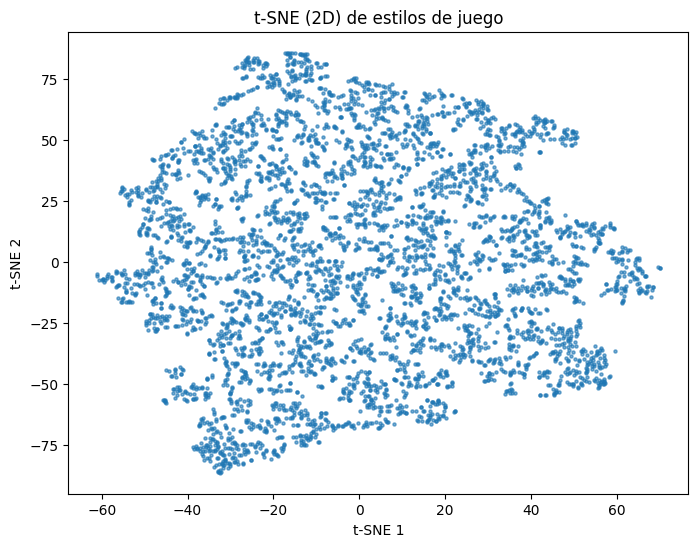

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ===== 1. Tomar una muestra para visualizar =====
n_muestra = 5000  # puedes subir/bajar este valor
df_sample = df_scaled.sample(n=n_muestra, random_state=42)

X = df_sample[vars_num].values   # solo variables numéricas

# ===== 2. Definir y entrenar t-SNE =====
tsne = TSNE(
    n_components=2,      # 2D
    perplexity=30,       # tamaño "efectivo" de vecindario
    learning_rate=200,
    n_iter=1000,
    init="random",
    random_state=42
)

X_tsne = tsne.fit_transform(X)

# ===== 3. Graficar =====
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.6)
plt.title("t-SNE (2D) de estilos de juego")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=591b7bf2-3c59-4355-9309-58b828d2cf19' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [17]:
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ---------- 1. Reducir dimensionalidad (ya tienen el robust scaler aplicado) ----------
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

embedding = umap_model.fit_transform(df_scaled[vars_num])

# ---------- 2. K-Means ----------
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)

# ---------- 3. Gaussian Mixture Models ----------
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(embedding)

# ---------- 4. HDBSCAN ----------
hdb = hdbscan.HDBSCAN(
    min_samples=20,
    min_cluster_size=50
)
hdb_labels = hdb.fit_predict(embedding)


ModuleNotFoundError: No module named 'hdbscan'